In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import umap
import umap.plot
from synthdata import trace_clusters 
from scipy.spatial import ConvexHull

In the following cell we generate some synthetic data. It generates randomly-varying sinusoid-type time series. The resulting traces matrix will be of size (n_samps x n_clusters, pnts). The rows representing the examples, and the columns represetning the "features".

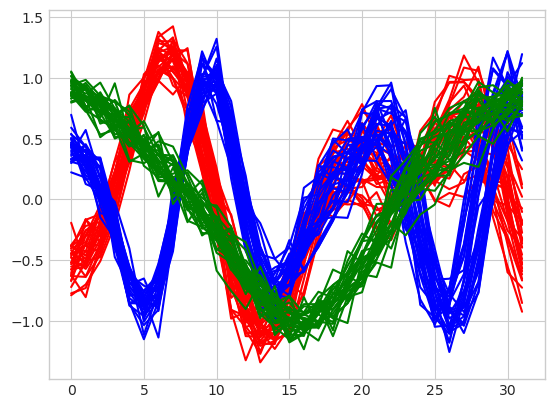

In [29]:
# Generate our synthetic data
n_samps = 30 # Number of traces to generate in each cluster
n_clusters = 3 # Number of clusters
_, traces, targs = trace_clusters(n_samps,
                                  plot=True,mode='flat',sf=0.05,
                                  ns_lvl=0.1,pnts=32,
                                  n_clusters=n_clusters)

In [ ]:
# We'll do this as an unsupervised task...
mapper = umap.UMAP(n_neighbors=10, random_state=42).fit(traces)

# but we could provide our cluster labels as well and make it supervised
#mapper = umap.UMAP(n_neighbors=10, random_state=42).fit(traces, y=targs)

# For generative purposes, we want to sample a grid of points spanning 
# our clusters in the 2D space.

# Get a rectangular bounding box around the clusters in the new 2D space
[x1,y2] = mapper.embedding_.min(axis=0)
[x2,y1] = mapper.embedding_.max(axis=0)

corners = np.array([
    [x1, y1],  # upper left
    [x2, y1],  # upper right
    [x1, y2],  # lower left
    [x2, y2],  # lower right
])

# Generate a grid of sampling points within this rectangle
test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

hull = ConvexHull(mapper.embedding_) #We'll use this later

# Pass the array of 2D grid points into our fitted umap operator inversion
# operation to return their high-dimensional represenation (32 in this case)
inv_transformed_points = mapper.inverse_transform(test_pts)

The variable inv_transformed_points is a 100 x 32 numpy array, representing the 10 x 10 "up-dimensioned" grid points. In the next cell we plot the results.

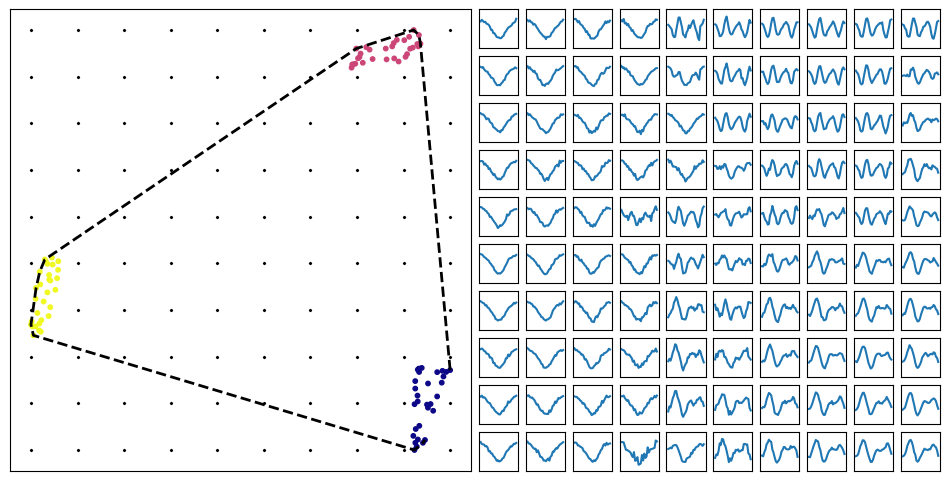

In [63]:
# Set up the grid
fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
generated_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        generated_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],
                   c=targs, cmap='plasma', s=10)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the test points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=2)
# Plot the convex hull
scatter_ax.plot(mapper.embedding_[hull.vertices,0],
                mapper.embedding_[hull.vertices,1], 'k--', lw=2)
scatter_ax.grid()

# Plot each of the generated time series
for i in range(10):
    for j in range(10):
        generated_axes[i, j].plot(inv_transformed_points[i*10 + j])
        generated_axes[i, j].set(xticks=[], yticks=[])
        generated_axes[i, j].set(ylim=[-2,2])

Okay the cluster colours here don't match the original trace plots - should fix this. But you should be able to tell which is which from the time series shapes. In the above, some of our grid points extend beyond the convex hull of the clusters (dashed black line), which isn't recommended.